# EDA on Processed Training Data

This notebook inspects the output of the `generate_dataset` Beam pipeline. We will check data quality, distributions, and relationships between features.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow.parquet as pq

sns.set_theme(style="whitegrid")
%matplotlib inline

## 1. Load Data
Loading the locally downloaded parquet file (downloaded from GCS output).

In [2]:
DATA_PATH = '../local_artifacts/processed_data/training_data.parquet'

try:
    df = pd.read_parquet(DATA_PATH)
    print(f"Loaded dataset with {df.shape[0]} rows and {df.shape[1]} columns.")
except FileNotFoundError:
    print(f"File not found at {DATA_PATH}. Please ensure you have downloaded the data from GCS.")

Loaded dataset with 75316 rows and 20 columns.


## 2. Basic Inspection

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75316 entries, 0 to 75315
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   trip_uid             75316 non-null  object 
 1   trip_date            75316 non-null  object 
 2   arrival_time         75316 non-null  object 
 3   timestamp            75316 non-null  float64
 4   group_id             75316 non-null  object 
 5   route_id             75316 non-null  object 
 6   direction            75316 non-null  object 
 7   stop_id              75316 non-null  object 
 8   time_idx             75316 non-null  int64  
 9   day_of_week          75316 non-null  int64  
 10  hour_sin             75316 non-null  float64
 11  hour_cos             75316 non-null  float64
 12  regime_id            75316 non-null  object 
 13  track_id             75316 non-null  object 
 14  service_headway      75312 non-null  float64
 15  preceding_train_gap  75314 non-null 

In [4]:
df.head()

,trip_uid,trip_date,arrival_time,timestamp,group_id,route_id,direction,stop_id,time_idx,day_of_week,hour_sin,hour_cos,regime_id,track_id,service_headway,preceding_train_gap,empirical_median,travel_time_14th,travel_time_23rd,travel_time_34th
0,1752815340_A..S53R,2025-07-18 05:09:00+00:00,2025-07-18T09:42:36+00:00,1.752832e+09,A_South,A,S,A32S,29213862,4,0.566406,-0.824126,Day,A3,12.666667,NaN,17.366667,2.000000,NaN,4.416667
1,1752816300_A..S58R,2025-07-18 05:25:00+00:00,2025-07-18T10:00:11+00:00,1.752833e+09,A_South,A,S,A32S,29213880,4,0.500000,-0.866025,Day,A3,17.583333,17.583333,10.625000,2.000000,NaN,NaN
2,1752817230_A..S57R,2025-07-18 05:40:30+00:00,2025-07-18T10:12:37+00:00,1.752834e+09,A_South,A,S,A32S,29213892,4,0.453990,-0.891007,Day,A3,12.433333,12.433333,10.625000,NaN,NaN,3.933333
3,1752818010_A..S58R,2025-07-18 05:53:30+00:00,2025-07-18T10:23:36+00:00,1.752834e+09,A_South,A,S,A32S,29213903,4,0.410719,-0.911762,Day,A3,10.983333,10.983333,10.625000,1.833333,NaN,NaN
4,1752818580_A..S57R,2025-07-18 06:03:00+00:00,2025-07-18T10:32:36+00:00,1.752835e+09,A_South,A,S,A32S,29213912,4,0.374607,-0.927184,Day,A3,9.000000,9.000000,10.625000,NaN,NaN,3.916667


## 3. Data Quality Checks
Checking for null values in key columns.

In [5]:
null_counts = df.isnull().sum()
null_counts[null_counts > 0]

service_headway            4
preceding_train_gap        2
travel_time_14th       27792
travel_time_23rd       42864
travel_time_34th       24692
dtype: int64

### Check Target Variable (`service_headway`)

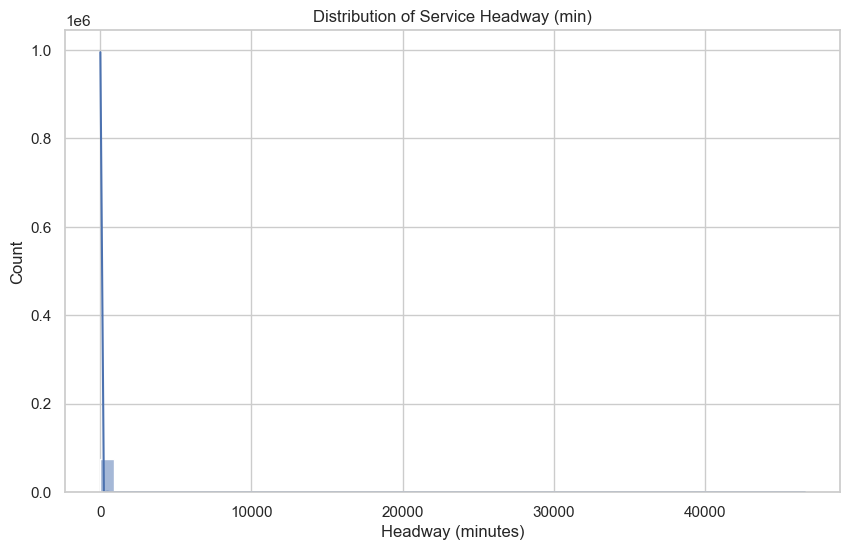

In [6]:
plt.figure(figsize=(10, 6))
sns.histplot(df['service_headway'], bins=50, kde=True)
plt.title('Distribution of Service Headway (min)')
plt.xlabel('Headway (minutes)')
plt.show()

In [8]:
print("Headway Statistics:")
df['service_headway'].describe()

Headway Statistics:


count    75312.000000
mean        13.998284
std        243.856823
min          0.000000
25%          5.166667
50%          8.333333
75%         12.116667
max      46613.366667
Name: service_headway, dtype: float64

## 4. Feature Relationships
Analyzing the relationship between valid existing travel times and the target headway.

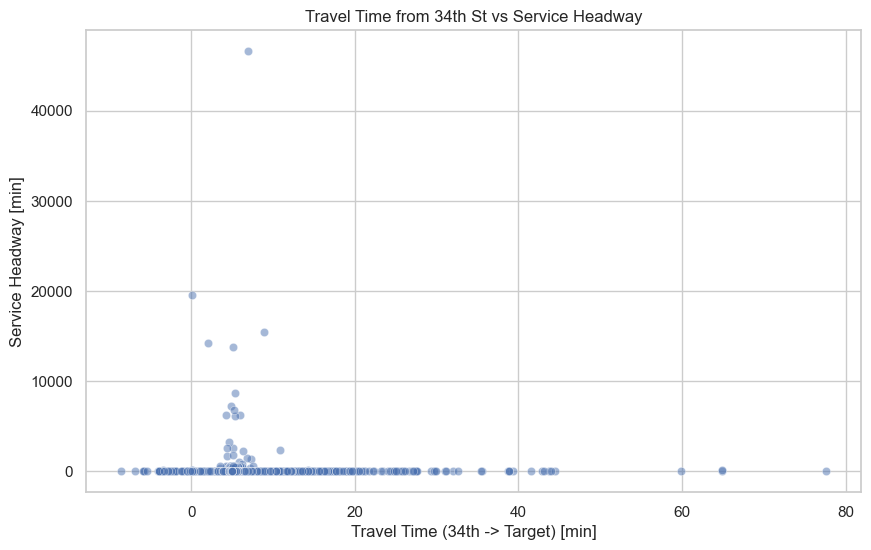

In [9]:
# Filter for rows where travel_time_34th is not null
valid_tt = df.dropna(subset=['travel_time_34th'])

plt.figure(figsize=(10, 6))
sns.scatterplot(data=valid_tt, x='travel_time_34th', y='service_headway', alpha=0.5)
plt.title('Travel Time from 34th St vs Service Headway')
plt.xlabel('Travel Time (34th -> Target) [min]')
plt.ylabel('Service Headway [min]')
plt.show()

### Correlation Matrix

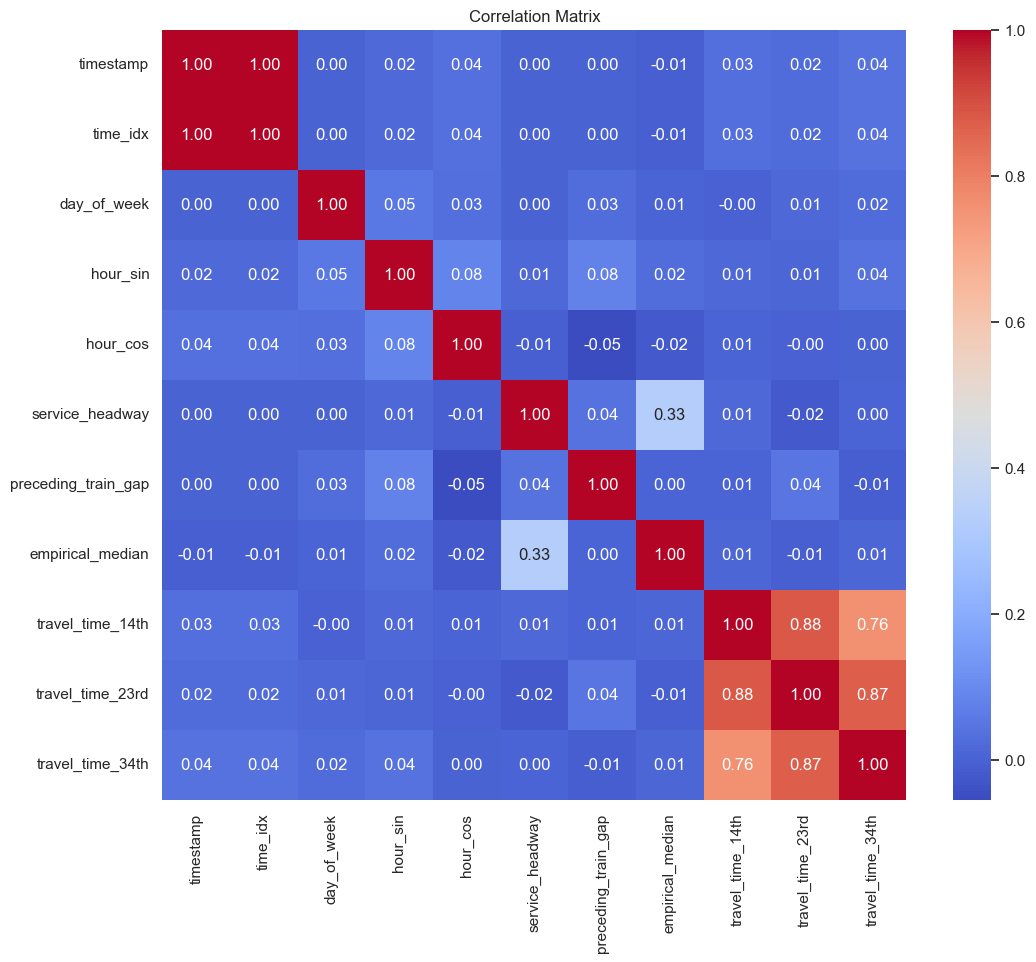

In [10]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
corr = df[numeric_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

## 5. Temporal Analysis

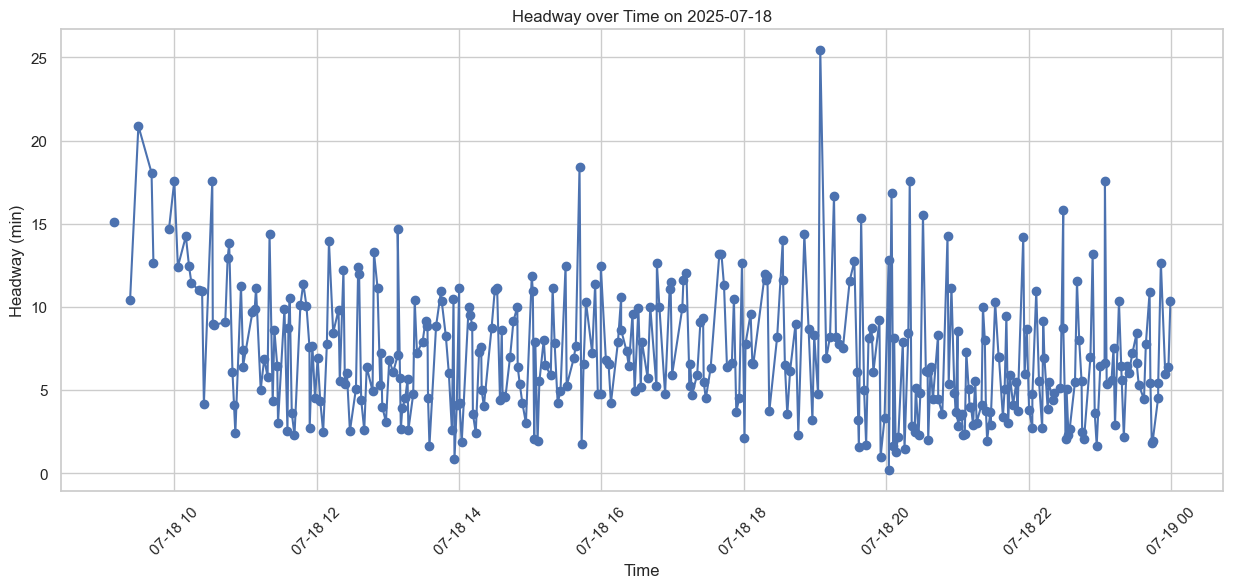

In [11]:
try:
    # Convert arrival_time back to datetime for plotting
    df['dt'] = pd.to_datetime(df['arrival_time'])
    
    # Plot headway over time for a sample day
    sample_day = df['dt'].dt.date.iloc[0]
    daily_data = df[df['dt'].dt.date == sample_day].sort_values('dt')
    
    plt.figure(figsize=(15, 6))
    plt.plot(daily_data['dt'], daily_data['service_headway'], marker='o')
    plt.title(f'Headway over Time on {sample_day}')
    plt.ylabel('Headway (min)')
    plt.xlabel('Time')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()
except Exception as e:
    print(f"Could not plot time series: {e}")

## Diagnosis: Investigating Null Travel Times
Investigating **Hypothesis A** (Track-Specific Nulls) and **Hypothesis B** (Simultaneous Nulls) to explain the missing data in `travel_time_34th` and `travel_time_14th`.

1. **Track-Specific**: A3/A4 are express tracks. If the A train runs express, it won't stop at local stations (like 23rd St), explaining nulls there. We need to check if 34th/14th nulls are also track-specific.
2. **Simultaneous Nulls**: If both 34th and 14th are null for the same trip, it suggests a "Session Boundary" or "Park and Wait" logic issue where no upstream data was available at all.

In [14]:
# Reload data to ensure we have the latest file
df = pd.read_parquet(DATA_PATH)

print("--- Null Rates by Track ID ---")
# Check if nulls are specific to Express (A3) vs Local (A1) tracks
track_nulls = df.groupby('track_id')[['travel_time_34th', 'travel_time_23rd', 'travel_time_14th']].apply(lambda x: x.isnull().mean())
print(track_nulls)

print("\n--- Simultaneous Nulls (34th & 14th) ---")
# Count rows where BOTH upstream stations are null
both_null_mask = (df['travel_time_34th'].isnull()) & (df['travel_time_14th'].isnull())
both_null_count = both_null_mask.sum()
total_rows = len(df)

print(f"Total Rows: {total_rows}")
print(f"Rows with BOTH 34th and 14th Null: {both_null_count} ({both_null_count/total_rows:.1%})")

print("\n--- Correlation of Nulls ---")
# If 34th is null, is 14th ALWAYS null?
subset_34th_null = df[df['travel_time_34th'].isnull()]
print(f"Given 34th is Null, % that 14th is also Null: {subset_34th_null['travel_time_14th'].isnull().mean():.1%}")

--- Null Rates by Track ID ---
          travel_time_34th  travel_time_23rd  travel_time_14th
track_id                                                      
A1                0.352323          0.376259          0.387488
A3                0.273215          0.999571          0.327755

--- Simultaneous Nulls (34th & 14th) ---
Total Rows: 75316
Rows with BOTH 34th and 14th Null: 7424 (9.9%)

--- Correlation of Nulls ---
Given 34th is Null, % that 14th is also Null: 30.1%


In [15]:
# Step 1: Find a "Victim" Trip
# We want a trip that:
# 1. Is on Track A3 (Express, so it definitely stops at 34th)
# 2. Has a NULL travel_time_34th (The problem)
# 3. Has a VALID travel_time_14th (Proof that some upstream data worked, making it a partial failure)

victim_df = df[
    (df['track_id'] == 'A3') & 
    (df['travel_time_34th'].isnull()) & 
    (df['travel_time_14th'].notnull())
]

if not victim_df.empty:
    victim_trip = victim_df.iloc[0]
    victim_id = victim_trip['trip_uid']
    print(f"Victim Trip ID: {victim_id}")
    print(f"Target Arrival (W4th): {victim_trip['arrival_time']}")
    print(f"Travel Time 14th: {victim_trip['travel_time_14th']} min")
    print(f"Travel Time 34th: {victim_trip['travel_time_34th']} (MISSING)")
    
    # Generate Query for verification
    print("\n--- BigQuery Check Command ---")
    print(f"SELECT * FROM `headway_prediction.ml_baseline` WHERE trip_uid = '{victim_id}' ORDER BY arrival_time;")
else:
    print("No mixed-null trips found on A3. Looking for ANY A3 trip with null 34th...")
    victim_df = df[(df['track_id'] == 'A3') & (df['travel_time_34th'].isnull())]
    if not victim_df.empty:
        victim_id = victim_df.iloc[0]['trip_uid']
        print(f"Victim Trip ID: {victim_id}")
        print("\n--- BigQuery Check Command ---")
        print(f"SELECT * FROM `headway_prediction.ml_baseline` WHERE trip_uid = '{victim_id}' ORDER BY arrival_time;")

Victim Trip ID: 1752816300_A..S58R
Target Arrival (W4th): 2025-07-18T10:00:11+00:00
Travel Time 14th: 2.0 min
Travel Time 34th: nan (MISSING)

--- BigQuery Check Command ---
SELECT * FROM `headway_prediction.ml_baseline` WHERE trip_uid = '1752816300_A..S58R' ORDER BY arrival_time;


## Diagnosis: Headway Outliers
Investigating massive outliers (32+ days) and zero-like headways.

1. **Mega-Gaps (> 120 min)**: Checking if these are due to "Session Reset" failures where state persists across days.
2. **Zeroes (< 0.5 min)**: Checking for duplicate events or "ghost trains".
3. **Core Distribution**: Verifying the distribution looks correct once outliers are filtered.

Mega Gaps Count: 252

--- Sample Mega Gap (Cross-Day Check) ---
Current Train: 2025-07-29 19:54:00+00:00
Headway: 9059 min
Implied Previous Train: 2025-07-23 12:55:22.000000002+00:00
Is Cross-Day? True

Zeroes Count (< 30s): 114
                trip_uid               arrival_time  service_headway route_id  \
68    1752852060_A..S58R  2025-07-18T20:02:02+00:00         0.166667        A   
1118  1753559970_A..S57R  2025-07-27T00:34:25+00:00         0.233333        A   
1422  1753783620_A..S58R  2025-07-29T15:06:02+00:00         0.366667        A   
1788  1753958955_A..S58R  2025-07-31T15:38:40+00:00         0.116667        A   
1810  1753979220_A..S58R  2025-07-31T21:18:40+00:00         0.133333        A   

     track_id  
68         A3  
1118       A3  
1422       A3  
1788       A3  
1810       A3  

Core Data Usage: 74907 / 75316 rows (99.5%)


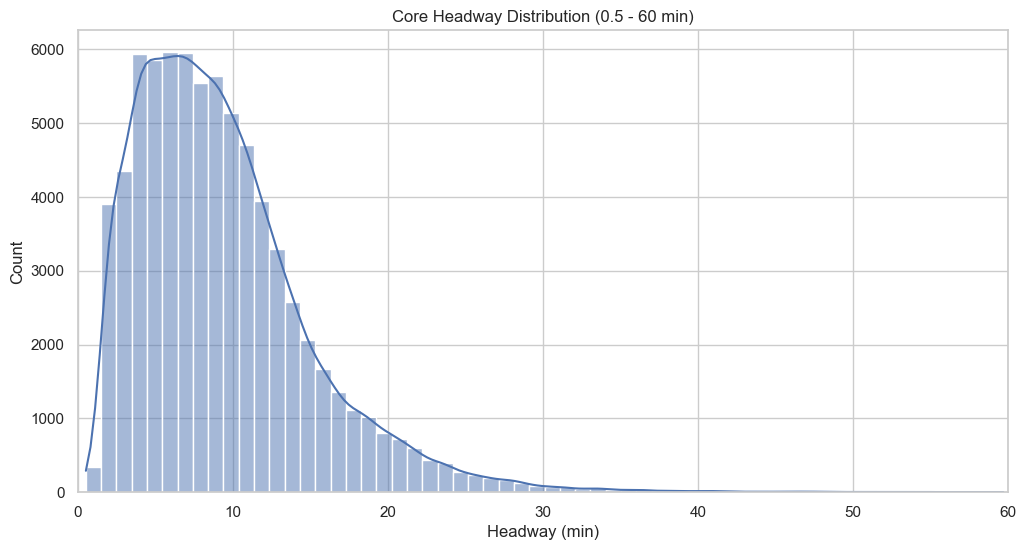

In [16]:
# 1. Investigate Mega-Gaps
mega_gaps = df[df['service_headway'] > 120].copy()
print(f"Mega Gaps Count: {len(mega_gaps)}")

if not mega_gaps.empty:
    # Calculate implied previous train timestamp
    mega_gaps['current_ts'] = pd.to_datetime(mega_gaps['arrival_time'])
    mega_gaps['prev_ts_implied'] = mega_gaps['current_ts'] - pd.to_timedelta(mega_gaps['service_headway'], unit='min')
    
    print("\n--- Sample Mega Gap (Cross-Day Check) ---")
    sample = mega_gaps.iloc[0]
    print(f"Current Train: {sample['current_ts']}")
    print(f"Headway: {sample['service_headway']:.0f} min")
    print(f"Implied Previous Train: {sample['prev_ts_implied']}")
    print("Is Cross-Day?", sample['current_ts'].date() != sample['prev_ts_implied'].date())

# 2. Investigate Zeroes
zeroes = df[df['service_headway'] < 0.5]
print(f"\nZeroes Count (< 30s): {len(zeroes)}")
if not zeroes.empty:
    print(zeroes[['trip_uid', 'arrival_time', 'service_headway', 'route_id', 'track_id']].head())

# 3. Valid Core Distribution
core_df = df[(df['service_headway'] > 0.5) & (df['service_headway'] < 60)]
print(f"\nCore Data Usage: {len(core_df)} / {len(df)} rows ({len(core_df)/len(df):.1%})")

plt.figure(figsize=(12, 6))
sns.histplot(core_df['service_headway'], bins=60, kde=True)
plt.title('Core Headway Distribution (0.5 - 60 min)')
plt.xlabel('Headway (min)')
plt.xlim(0, 60)
plt.show()